In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from pathlib import Path

from time import sleep

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.utils import shuffle

from importlib import reload
import sentinel_utils
import keras_model_creator

2024-06-29 12:42:50.747369: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-29 12:42:50.750788: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-29 12:42:50.787360: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-29 12:42:51.737786: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
all_bands = [f'B{x}' for x in range(2, 9)] + ['B8A', 'B11', 'B12']
all_bands += ['Elevation']
selected_bands = all_bands
bands = [all_bands.index(b) for b in selected_bands]

In [3]:
reload(sentinel_utils)

shards_dir = Path.home().joinpath('sentinel_data').joinpath('shards')

data_tag = '2017_orig'
sort_key = lambda x: int(x.stem.split('_')[-1])
feature_shards = sorted(list(shards_dir.joinpath(f'features_{data_tag}').glob('feature_*.npy')), key=sort_key)

all_labels = pd.read_csv('full_dummies.csv')

sample_shards = 20000
utils = sentinel_utils.SentinelUtils(
    shuffle(feature_shards, random_state=42)[:sample_shards],
    all_labels, min_occurrences=5000, 
    overwrite_existing=False
)

IDs = utils.selected_classes.index

In [4]:
architecture = 'simple'
loss = 'binary_crossentropy'
normal_type = 'zscore'
dim = (np.load(feature_shards[0]).shape[:2])

model_dir = Path('models').joinpath(
    f'{architecture}-{loss}-{len(IDs)}-{utils.selected_classes.shape[1]}-{normal_type}'
)
model_dir.mkdir(parents=True, exist_ok=True)

model_dir

PosixPath('models/simple-binary_crossentropy-237797-30-log')

In [5]:
reload(keras_model_creator)

params = dict(
    normal_type=normal_type,
    utils=utils,
    dim=dim,
    shards_dir=shards_dir,
    data_tag=data_tag,
    IDs=IDs,
    model_dir=model_dir,
    bands=bands,
    architecture=architecture,
    loss=loss,
    batch_size=64,
    base_filters=32,
    dropout=0.0,
    epochs=1,
    overwrite=False
)

model, testing_generator = keras_model_creator.KerasModelCreator(**params).run()

Building model...
Fitting...
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 2167s 607ms/step - accuracy: 0.2701 - auc: 0.8783 - loss: 0.1762 - macrof1score: 0.1575 - microf1score: 0.3639 - prc: 0.4688 - precision: 0.6646 - recall: 0.2525 - weightedf1score: 0.3057 - val_accuracy: 0.2580 - val_auc: 0.8409 - val_loss: 0.2050 - val_macrof1score: 0.1245 - val_microf1score: 0.3106 - val_prc: 0.3780 - val_precision: 0.5499 - val_recall: 0.2164 - val_weightedf1score: 0.2221 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [6]:
eval_path = model_dir.joinpath('eval.csv')
if eval_path.is_file():
    print(pd.read_csv(eval_path))
else:
    r = model.evaluate(x=testing_generator, verbose=1, return_dict=True)
    df = pd.DataFrame.from_dict(r, orient='index', columns=['score'])
    df.to_csv(eval_path)
    print(df)

78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 360ms/step - accuracy: 0.2631 - auc: 0.8366 - loss: 0.2059 - macrof1score: 0.1263 - microf1score: 0.3043 - prc: 0.3729 - precision: 0.5511 - recall: 0.2102 - weightedf1score: 0.2182
                    score
accuracy         0.264423
auc              0.839461
loss             0.204533
macrof1score     0.125969
microf1score     0.309029
prc              0.374418
precision        0.550290
recall           0.214839
weightedf1score  0.220992


In [7]:
preds_path = model_dir.joinpath('preds.npy')
if preds_path.is_file():
    y_pred = np.load(preds_path)
else:
    y_pred = model.predict(x=testing_generator, verbose=1)
    np.save(preds_path, y_pred)

78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 353ms/step


In [8]:
labels_path = model_dir.joinpath('true.npy')
total_batches = testing_generator.__len__()
if labels_path.is_file():
    y_true = np.load(labels_path)
else:
    y_true = []
    for i, (x, y) in enumerate(tqdm(testing_generator, total=total_batches-1)):
        y_true.append(y)
        if i > total_batches - 2:
            break
    y_true = np.vstack(y_true)
    np.save(labels_path, y_true)

  0%|          | 0/77 [00:00<?, ?it/s]

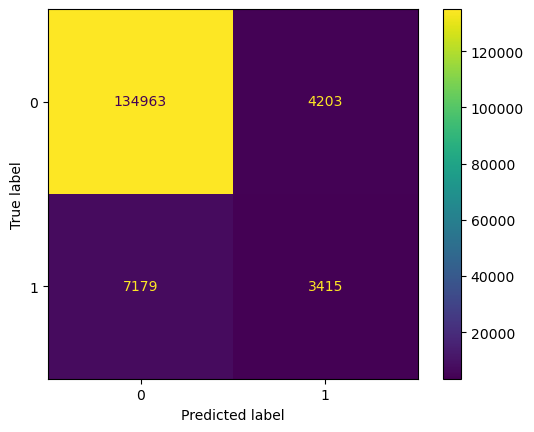

In [9]:
cm = confusion_matrix(y_true.flatten().astype(int), (y_pred > 0.3).flatten().astype(int))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

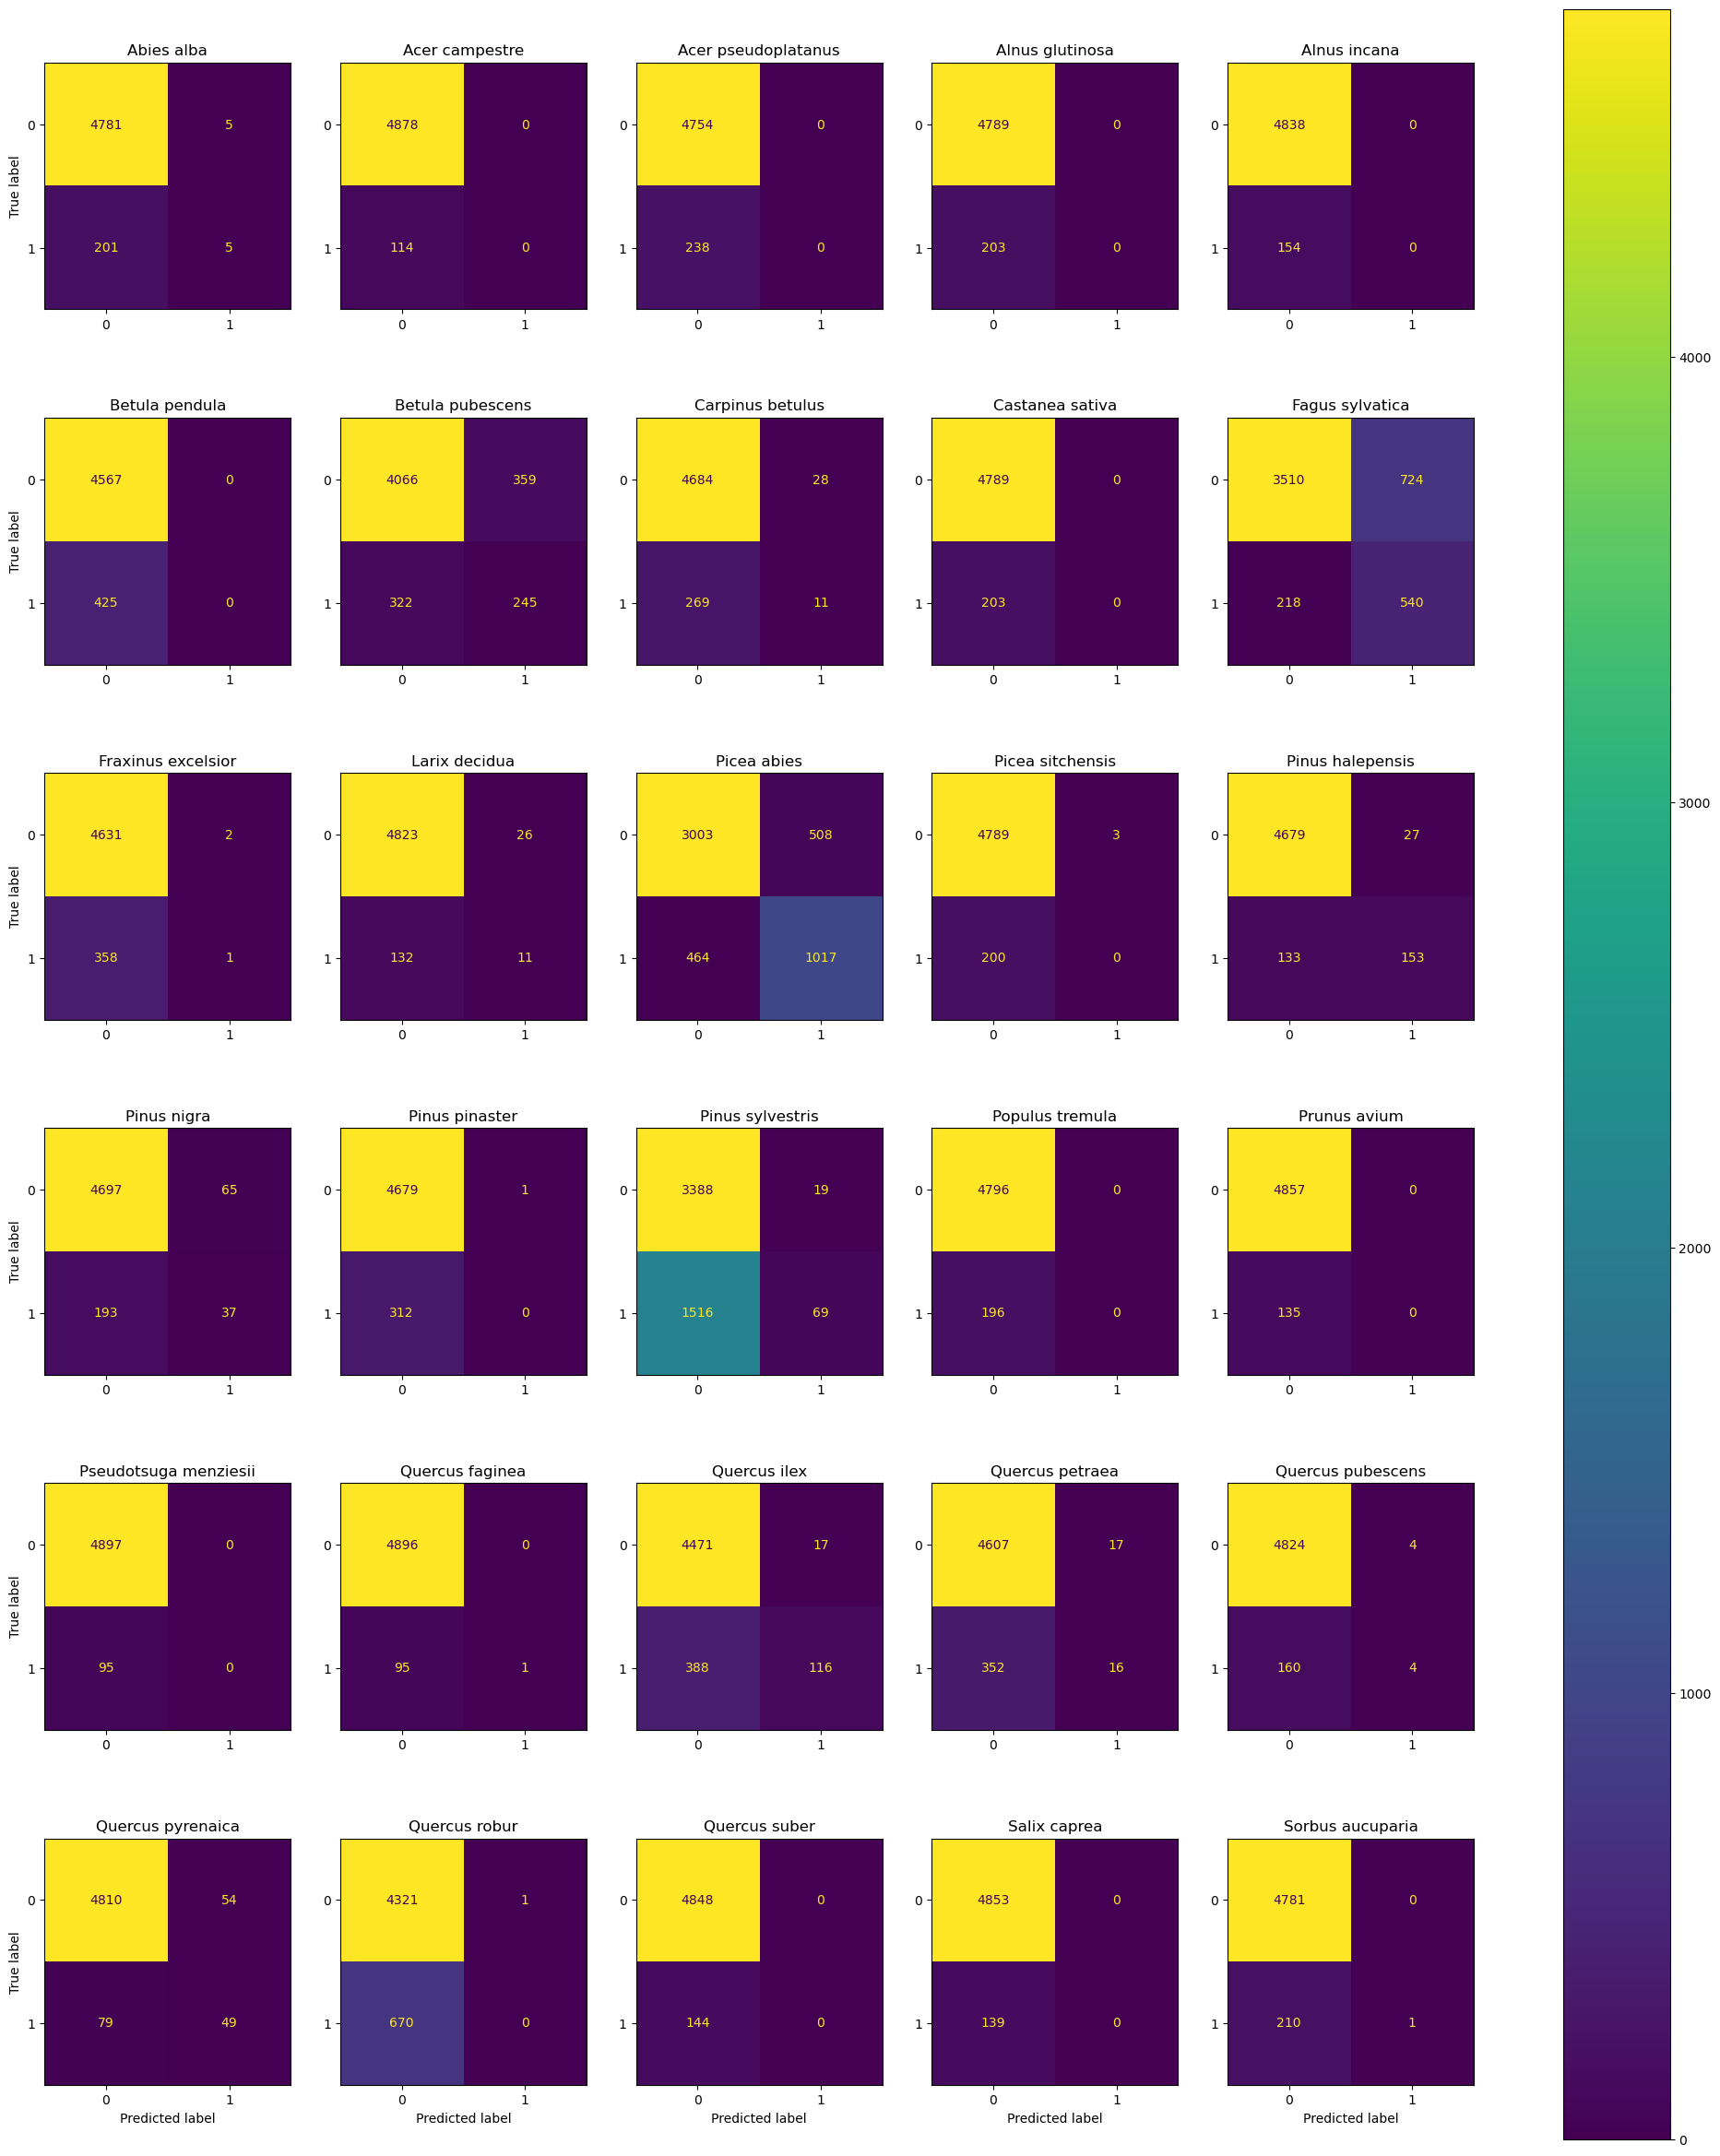

In [10]:
import matplotlib.pyplot as plt

class_names = utils.selected_classes.columns

f, axes = plt.subplots(6, 5, figsize=(25, 30))
axes = axes.ravel()
for label in range(y_true.shape[1]):
    cm = confusion_matrix(y_true[..., label].astype(int), (y_pred[..., label] > 0.5).astype(int))
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=axes[label], values_format='.4g')
    disp.ax_.set_title(f'{class_names[label]}')
    if label < 25:
        disp.ax_.set_xlabel('')
    if label % 5 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.2, hspace=0.001)
f.colorbar(disp.im_, ax=axes)
plt.show()


In [11]:
# tf.keras.utils.plot_model(model, show_shapes=True)
# model.summary()

In [12]:
# import subprocess
# subprocess.run(['sudo', 'shutdown', 'now'])